# Predictive Maintenance mit SCANIA-Daten – Evaluation

**Projekt:** Bachelorarbeit Data Science  
**Thema:** 
**Datengrundlage:** SCANIA Component X Dataset  
**Autor:** Justin Stange-Heiduk  
**Betreuung:** Dr. Martin Prause  
**Ziel:** Evaluation der Modelle XGBoost mit AFT und Random Forest Survival  

---

**Erstellt:** 2025-09-08
**Letzte Änderung:** 2025-09-08


---

In [185]:
import os
import pickle
import joblib
import json
from typing import Dict, Any, Iterable, Tuple
from sksurv.util import Surv
from sksurv.metrics import  brier_score
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import scipy



In [190]:
%run "0. CommonFunctions.ipynb"

### 1. RSF
#### 1.1 Brier-Score
#### 1.1 Kostenanalyse
### 2. XGBoost
#### 2.1 Brier-Score
#### 2.2 Kostenanalyse

### 1. RSF

#### Modell laden

In [119]:
def load_model(model_path: str) -> Any:
    """
    Load a trained survival model (RSF or AFT with XGBoost) from disk.

    Args:
        model_path (str):
            Name of the model directory inside ../data/06_models/.

    Returns:
        Any:
            - RandomSurvivalForest (per pickle/joblib)
            - xgb.Booster (wenn .xgb oder .json gespeichert wurde)
    """
    model_dir = os.path.join("../data/06_models", model_path)

    # Look for model files inside the directory
    candidates = [
        os.path.join(model_dir, f) for f in os.listdir(model_dir)
        if f.endswith((".pkl", ".joblib", ".xgb", ".json"))
    ]

    if not candidates:
        raise FileNotFoundError(
            f"No model file (.pkl, .joblib, .xgb, .json) found in {model_dir}"
        )

    model_file = candidates[0]

    try:
        if model_file.endswith(".joblib"):
            model = joblib.load(model_file)
        elif model_file.endswith(".pkl"):
            with open(model_file, "rb") as f:
                model = pickle.load(f)
        elif model_file.endswith(".xgb") or model_file.endswith(".json"):
            booster = xgb.Booster()
            booster.load_model(model_file)
            model = booster
        else:
            raise ValueError(f"Unsupported model format: {model_file}")
    except Exception as e:
        raise RuntimeError(f"Could not load model from {model_file}: {e}")

    return model

In [108]:
COST, TAUS = get_cost_and_taus()

#### 1.1 Brier-Score

In [206]:
def rsf_brier_score_on_test(
    rsf,
    X_test: pd.DataFrame,
    y_train_surv: np.ndarray,
    y_test_surv: np.ndarray,
    output_base: str = "../data/07_model_output",
    model_subdir: str = "RSF",
    time_grid: Iterable[float] | None = None
) -> Dict[str, Any]:
    out_dir = os.path.join(output_base, model_subdir)

    # Tau = maximaler Eventzeitpunkt im Test (keine Zensur)
    tau = float(y_test_surv["time"][y_test_surv["event"]].max())

    # Zeitraster nur bis tau
    if time_grid is None:
        times = np.linspace(1.0, tau, 100)
    else:
        times = np.asarray(list(time_grid), dtype=float)
        times = times[times < tau]

    surv_fns = rsf.predict_survival_function(X_test, return_array=False)
    S_mat = np.asarray([[fn(t) for t in times] for fn in surv_fns])

    times_out, bs_mean = brier_score(y_train_surv, y_test_surv, S_mat, times)

    ibs = float(np.trapz(bs_mean, times_out) / (times_out[-1] - times_out[0]))

    results = {
        "ibs": ibs,
        "tau": tau,
        "times": times_out.tolist(),
        "brier_scores": bs_mean.tolist(),
    }

    out_path = os.path.join(out_dir, "brier_score.json")
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2)

    results["path"] = out_path
    return results


#### Anwendung

In [225]:
rsf_model = load_model("RSF_final_model")

In [200]:
x_test, y_test = prepare_rsf_model_input(load_df(ordner="04_feature", name = "feature_test_corr_labels").drop(columns=["upper_bound"]), columns_to_drop=["duration", "event", "vehicle_id", "class_label"], frag=1.0, class_column="class_label", sampling=False) 
x_train, y_train = prepare_rsf_model_input(load_df(ordner="04_feature", name = "feature_train_corr_labels").drop(columns=["upper_bound"]), columns_to_drop=["duration", "event", "vehicle_id", "class"], frag=1.0, class_column="class", sampling=False) 


In [207]:
results_brier = rsf_brier_score_on_test(
    rsf=rsf_model,
    X_test=x_test,
    y_train_surv=y_train,   # für Zensierungsgewichte
    y_test_surv=y_test,     # Testdaten
    model_subdir="RSF"
)
print(results_brier)

{'ibs': 0.021587085889639278, 'tau': 47.0, 'times': [1.0, 1.4646464646464645, 1.9292929292929293, 2.393939393939394, 2.8585858585858586, 3.323232323232323, 3.787878787878788, 4.252525252525253, 4.717171717171717, 5.181818181818182, 5.646464646464646, 6.111111111111111, 6.575757575757576, 7.040404040404041, 7.505050505050505, 7.96969696969697, 8.434343434343434, 8.8989898989899, 9.363636363636363, 9.828282828282829, 10.292929292929292, 10.757575757575758, 11.222222222222221, 11.686868686868687, 12.151515151515152, 12.616161616161616, 13.080808080808081, 13.545454545454545, 14.01010101010101, 14.474747474747474, 14.93939393939394, 15.404040404040403, 15.868686868686869, 16.333333333333336, 16.7979797979798, 17.262626262626263, 17.727272727272727, 18.19191919191919, 18.656565656565657, 19.12121212121212, 19.585858585858585, 20.050505050505052, 20.515151515151516, 20.97979797979798, 21.444444444444443, 21.90909090909091, 22.373737373737374, 22.838383838383837, 23.303030303030305, 23.767676

#### Für das RSF Test Model 

In [210]:
rsf_model = load_model("RSF_final_model_test")

In [211]:
results_brier = rsf_brier_score_on_test(
    rsf=rsf_model,
    X_test=x_test,
    y_train_surv=y_train,   # für Zensierungsgewichte
    y_test_surv=y_test,     # Testdaten
    model_subdir="RSF_test"
)
print(results_brier)

{'ibs': 0.021587085889639278, 'tau': 47.0, 'times': [1.0, 1.4646464646464645, 1.9292929292929293, 2.393939393939394, 2.8585858585858586, 3.323232323232323, 3.787878787878788, 4.252525252525253, 4.717171717171717, 5.181818181818182, 5.646464646464646, 6.111111111111111, 6.575757575757576, 7.040404040404041, 7.505050505050505, 7.96969696969697, 8.434343434343434, 8.8989898989899, 9.363636363636363, 9.828282828282829, 10.292929292929292, 10.757575757575758, 11.222222222222221, 11.686868686868687, 12.151515151515152, 12.616161616161616, 13.080808080808081, 13.545454545454545, 14.01010101010101, 14.474747474747474, 14.93939393939394, 15.404040404040403, 15.868686868686869, 16.333333333333336, 16.7979797979798, 17.262626262626263, 17.727272727272727, 18.19191919191919, 18.656565656565657, 19.12121212121212, 19.585858585858585, 20.050505050505052, 20.515151515151516, 20.97979797979798, 21.444444444444443, 21.90909090909091, 22.373737373737374, 22.838383838383837, 23.303030303030305, 23.767676

#### 1.2 Kostenanalyse

In [181]:
def ensure_dir(path: str) -> None:
    """Erzeugt das Zielverzeichnis, falls es nicht existiert."""
    os.makedirs(path, exist_ok=True)

In [182]:
def class_probs_from_S_tau(S_tau_row: np.ndarray) -> np.ndarray:
    """
    Berechnet Klassenwahrscheinlichkeiten p0..p4 aus S(tau1..tau4) für eine Instanz.

    Args:
        S_tau_row (np.ndarray):
            Array der Länge 4 mit S(tau1), S(tau2), S(tau3), S(tau4).

    Returns:
        np.ndarray:
            Vektor der Länge 5 mit Wahrscheinlichkeiten [p0, p1, p2, p3, p4], Summe = 1.
    """
    S1, S2, S3, S4 = S_tau_row.tolist()
    p4 = 1.0 - S1
    p3 = S1 - S2
    p2 = S2 - S3
    p1 = S3 - S4
    p0 = S4
    p = np.array([p0, p1, p2, p3, p4], dtype=float)
    p = np.clip(p, 0.0, 1.0)
    s = p.sum()
    return p / s if s > 0 else np.array([1.0, 0.0, 0.0, 0.0, 0.0], dtype=float)

In [183]:
def decide_with_cost_from_rsf_at_taus(
    rsf,
    X: pd.DataFrame,
    taus: np.ndarray,
    cost: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Ermittelt je Instanz die kostenminimale Klasse m_hat und die zugehörigen Größen.

    Args:
        rsf:
            Trainiertes RandomSurvivalForest‐Modell mit
            predict_survival_function(X, return_array=False).
        X (pd.DataFrame):
            Merkmalstabelle mit N Zeilen. Die Spaltenreihenfolge muss zu rsf passen.
        taus (np.ndarray):
            Klassengrenzen als Array der Länge 4 in aufsteigender Reihenfolge.
        cost (np.ndarray):
            Kostenmatrix C der Form (5, 5). Zeilen sind true Klassen, Spalten predicted Klassen.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]:
            pred_class: Länge N mit vorhergesagter Klasse {0..4}.
            exp_cost_min: Länge N mit minimaler erwarteter Kosten pro Instanz.
            probs: Matrix (N, 5) mit Wahrscheinlichkeiten p0..p4.
    """
    surv_fns = rsf.predict_survival_function(X, return_array=False)
    N = len(X)

    # S(tau) pro Instanz robust auswerten: einzelne Zeitpunkte können Skalar liefern
    taus = np.asarray(taus, dtype=float)
    S_tau = np.zeros((N, len(taus)), dtype=float)
    for i, fn in enumerate(surv_fns):
        vals = fn(taus)
        if np.ndim(vals) == 0:
            # Falls Modell einen Skalar zurückgibt, replizieren wir für Sicherheit
            S_tau[i, :] = float(vals)
        else:
            S_tau[i, :] = np.asarray(vals, dtype=float)

    # Klassenwahrscheinlichkeiten für jede Zeile
    probs = np.vstack([class_probs_from_S_tau(S_tau[i, :]) for i in range(N)])  # (N,5)

    # Erwartete Kosten je vorhergesagter Klasse m: E[C|x, m] = p @ C[:, m]
    # Wir können das vektorisieren: exp_cost_matrix hat Form (N, 5)
    exp_cost_matrix = probs @ cost
    pred_class = exp_cost_matrix.argmin(axis=1).astype(int)
    exp_cost_min = exp_cost_matrix[np.arange(N), pred_class].astype(float)
    return pred_class, exp_cost_min, probs

#### decider function

In [ ]:

def evaluate_decision_costs_from_true(
    true_class: pd.Series | np.ndarray,
    pred_class: np.ndarray,
    cost: np.ndarray
) -> Tuple[float, float, np.ndarray]:
    """
    Berechnet durchschnittliche und totale realisierte Kosten sowie die Konfusionsmatrix.

    Args:
        true_class (pd.Series | np.ndarray):
            Vektor der Länge N mit wahren Klassen {0..4}.
        pred_class (np.ndarray):
            Vektor der Länge N mit vorhergesagten Klassen {0..4}.
        cost (np.ndarray):
            Kostenmatrix C der Form (5, 5). Zeilen true, Spalten predicted.

    Returns:
        Tuple[float, float, np.ndarray]:
            avg_cost: Durchschnittliche realisierte Kosten über N Instanzen.
            total_cost: Summe der realisierten Kosten.
            cm: Konfusionsmatrix mit Form (5, 5) in der Reihenfolge Klassen 0..4.
            accuracy: Anteil korrekter Vorhersagen.
    """
    n = np.asarray(true_class, dtype=int)
    m = np.asarray(pred_class, dtype=int)
    if n.shape != m.shape:
        raise ValueError("true_class und pred_class müssen gleich lang sein.")

    cm = confusion_matrix(n, m, labels=[0, 1, 2, 3, 4])
    # Realisierte Kosten aus cm und C: Sum_{n,m} cm[n,m] * C[n,m]
    realized_total = float(np.sum(cm * cost))
    avg_cost = realized_total / float(len(n))
    accuracy = float(np.mean(n == m))
    return avg_cost, realized_total, cm, accuracy

In [83]:
def evaluate_and_save_cost_decision_rsf(
    rsf,
    X_eval: pd.DataFrame,
    true_class: pd.Series | np.ndarray,
    taus: np.ndarray,
    cost: np.ndarray,
    output_dir: str = "../data/07_model_output/RSF",
    save_probs: bool = False,
    survix: str = "cost"
) -> dict:
    """
    Führt die kostenbasierte Entscheidung durch, berechnet realisierte Kosten und speichert Artefakte.

    Args:
        rsf:
            Trainiertes RandomSurvivalForest‐Modell.
        X_eval (pd.DataFrame):
            Evaluationsfeatures. Spaltenreihenfolge wird an rsf.feature_names_in_ angepasst, falls vorhanden.
        true_class (pd.Series | np.ndarray):
            Wahre Klassenlabels {0..4} in der Reihenfolge der Zeilen von X_eval.
        taus (np.ndarray):
            Klassengrenzen [tau1, tau2, tau3, tau4].
        cost (np.ndarray):
            Kostenmatrix C (5x5).
        output_dir (str):
            Zielordner für Outputs.
        save_probs (bool):
            Ob die Klassenwahrscheinlichkeiten pro Instanz gespeichert werden sollen.
        survix (str):
            Suffix für die gespeicherten Dateien, z.B. "cost"

    Returns:
        dict:
            Pfade zu gespeicherten Dateien und Kennzahlen.
    """
    ensure_dir(output_dir)

    # Spaltenausrichtung, falls das Modell diese Information besitzt
    if hasattr(rsf, "feature_names_in_"):
        X_eval = X_eval.loc[:, rsf.feature_names_in_]

    pred_class, exp_cost_min, probs = decide_with_cost_from_rsf_at_taus(rsf, X_eval, taus, cost)
    avg_cost, total_cost, cm, accuracy = evaluate_decision_costs_from_true(true_class, pred_class, cost)

    # Speichern
    metrics = {
        "avg_realised_cost": float(avg_cost),
        "total_realised_cost": float(total_cost),
        "accuracy": float(accuracy),
        "n_instances": int(len(pred_class)),
        "taus": list(map(float, taus)),
    }
    with open(os.path.join(output_dir, f"metrics_{survix}.json"), "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)

    pd.DataFrame(cm, index=[0, 1, 2, 3, 4], columns=[0, 1, 2, 3, 4]).to_csv(
        os.path.join(output_dir, f"confusion_matrix_{survix}.csv"), index=True
    )

    if save_probs:
        pd.DataFrame(probs, columns=[f"p{c}" for c in range(5)]).to_csv(
            os.path.join(output_dir, f"class_probs_{survix}.csv"), index=False
        )

    # Rückgabe
    return {
        "metrics_cost_path": os.path.join(output_dir, f"metrics_{survix}.json"),
        "confusion_matrix_path": os.path.join(output_dir, f"confusion_matrix_{survix}.csv"),
        "class_probs_path": os.path.join(output_dir, f"class_probs_{survix}.csv") if save_probs else None,
        "avg_realised_cost": float(avg_cost),
        "total_realised_cost": float(total_cost),
        "accuracy": float(accuracy),
    }

#### Evaulation function

In [54]:
def run_rsf_cost_evaluation_cost(
    rsf_model,
    X_eval,
    true_class,
    taus,
    cost,
    output_dir="../data/07_model_output/RSF",
    save_probs=True,
    survix="cost"
):
    """
    Führt die kostenbasierte Evaluation für ein Random Survival Forest Modell durch und gibt die Ergebnisse aus.

    Args:
        rsf_model: Das trainierte Random Survival Forest Modell.
        X_eval (pd.DataFrame): Feature-Matrix für die Evaluation (z.B. x_test oder x_val).
        true_class (pd.Series oder np.ndarray): Wahre Klassenlabels für die Evaluationsdaten.
        taus (np.ndarray): Array mit Klassengrenzen (z.B. [tau1, tau2, tau3, tau4]).
        cost (np.ndarray): Kostenmatrix der Form (5, 5).
        output_dir (str, optional): Zielverzeichnis für Output-Dateien. Standard: "../data/07_model_output/RSF".
        save_probs (bool, optional): Ob die Klassenwahrscheinlichkeiten gespeichert werden sollen. Standard: True.
        survix (str, optional): Suffix für Output-Dateien. Standard: "cost".

    Returns:
        dict: Dictionary mit Pfaden zu gespeicherten Dateien und Kennzahlen.
    """
    results_cost = evaluate_and_save_cost_decision_rsf(
        rsf=rsf_model,
        X_eval=X_eval,
        true_class=true_class,
        taus=taus,
        cost=cost,
        output_dir=output_dir,
        save_probs=save_probs,
        survix=survix
    )
    
    return results_cost

#### Anwendung

In [81]:
rsf_model = load_model("RSF_final_model")

In [84]:
results_cost = run_rsf_cost_evaluation_cost(
    rsf_model=rsf_model,
    X_eval=x_test,                         
    true_class=test_data["class_label"], 
    taus=TAUS,
    cost=COST,
    output_dir="../data/07_model_output/RSF",
    save_probs=True,
    survix = "cost"
)
print(results_cost)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   5 tasks      | elapsed:    1.4s


{'metrics_cost_path': '../data/07_model_output/RSF/metrics_cost.json', 'confusion_matrix_path': '../data/07_model_output/RSF/confusion_matrix_cost.csv', 'class_probs_path': '../data/07_model_output/RSF/class_probs_cost.csv', 'avg_realised_cost': 8.983541542732501, 'total_realised_cost': 45304.0, 'accuracy': 0.5770374776918501}


[Parallel(n_jobs=18)]: Done 128 out of 128 | elapsed:    7.3s finished


#### Mit Test RSF Modell

In [85]:
rsf_model = load_model("RSF_final_model_test")

In [86]:
results_cost = run_rsf_cost_evaluation_cost(
    rsf_model=rsf_model,
    X_eval=x_test,                         
    true_class=test_data["class_label"], 
    taus=TAUS,
    cost=COST,
    output_dir="../data/07_model_output/RSF_test",
    save_probs=True,
    survix = "cost"
)
print(results_cost)

{'metrics_cost_path': '../data/07_model_output/RSF_test/metrics_cost.json', 'confusion_matrix_path': '../data/07_model_output/RSF_test/confusion_matrix_cost.csv', 'class_probs_path': '../data/07_model_output/RSF_test/class_probs_cost.csv', 'avg_realised_cost': 8.513781479278208, 'total_realised_cost': 42935.0, 'accuracy': 0.5038667459845331}


#### Entscheidung nach Argmax

In [ ]:
def decide_with_argmax_from_rsf_at_taus(
    rsf,
    X: pd.DataFrame,
    taus: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Ermittelt je Instanz die Klasse mit maximaler Wahrscheinlichkeit (argmax).

    Args:
        rsf: trainiertes RandomSurvivalForest Modell.
        X (pd.DataFrame): Eingabedaten (N, n_features).
        taus (np.ndarray): Klassengrenzen [tau1..tau4].

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]:
            pred_class: Länge N, argmax(p0..p4).
            max_probs: Länge N, zugehörige max. Wahrscheinlichkeit.
            probs: Matrix (N,5) mit Wahrscheinlichkeiten p0..p4.
    """
    surv_fns = rsf.predict_survival_function(X, return_array=False)
    N = len(X)

    taus = np.asarray(taus, dtype=float)
    S_tau = np.zeros((N, len(taus)), dtype=float)
    for i, fn in enumerate(surv_fns):
        vals = fn(taus)
        if np.ndim(vals) == 0:
            S_tau[i, :] = float(vals)
        else:
            S_tau[i, :] = np.asarray(vals, dtype=float)

    probs = np.vstack([class_probs_from_S_tau(S_tau[i, :]) for i in range(N)])  # (N,5)
    pred_class = probs.argmax(axis=1).astype(int)
    max_probs = probs[np.arange(N), pred_class]
    return pred_class, max_probs, probs

#### decider function

In [71]:
def evaluate_and_save_argmax_decision_rsf(
    rsf,
    X_eval: pd.DataFrame,
    true_class: pd.Series | np.ndarray,
    taus: np.ndarray,
    cost: np.ndarray,
    output_dir: str = "../data/07_model_output/RSF",
    save_probs: bool = False,
    survix: str = "argmax"
) -> dict:
    """
    Führt die argmax-Entscheidung durch (Klasse mit höchster Wahrscheinlichkeit),
    berechnet realisierte Kosten & Konfusionsmatrix und speichert Artefakte.

    Args:
        rsf: trainiertes RandomSurvivalForest Modell.
        X_eval: Features zur Evaluation.
        true_class: wahre Klassen {0..4}.
        taus: Klassengrenzen [tau1..tau4].
        cost: Kostenmatrix (5x5), dient nur zur Kostenbewertung.
        output_dir: Zielordner für Artefakte.
        save_probs: Ob Wahrscheinlichkeiten abgespeichert werden sollen.
        survix: Suffix für Dateinamen (z. B. "argmax").

    Returns:
        dict mit Pfaden und Kennzahlen.
    """
    ensure_dir(output_dir)

    if hasattr(rsf, "feature_names_in_"):
        X_eval = X_eval.loc[:, rsf.feature_names_in_]

    pred_class, max_probs, probs = decide_with_argmax_from_rsf_at_taus(rsf, X_eval, taus)
    avg_cost, total_cost, cm, accuracy = evaluate_decision_costs_from_true(true_class, pred_class, cost)

    # Dateipfade mit Suffix
    metrics_path = os.path.join(output_dir, f"metrics_{survix}.json")
    cm_path = os.path.join(output_dir, f"confusion_matrix_{survix}.csv")
    probs_path = os.path.join(output_dir, f"class_probs_{survix}.csv")

    metrics = {
        "avg_realised_cost": float(avg_cost),
        "total_realised_cost": float(total_cost),
        "accuracy": float(accuracy),
        "n_instances": int(len(pred_class)),
        "taus": list(map(float, taus)),
    }
    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)

    pd.DataFrame(cm, index=[0, 1, 2, 3, 4], columns=[0, 1, 2, 3, 4]).to_csv(cm_path, index=True)

    if save_probs:
        pd.DataFrame(probs, columns=[f"p{c}" for c in range(5)]).to_csv(probs_path, index=False)

    return {
        "metrics_path": metrics_path,
        "confusion_matrix_path": cm_path,
        "class_probs_path": probs_path if save_probs else None,
        "avg_realised_cost": float(avg_cost),
        "total_realised_cost": float(total_cost),
        "accuracy": float(accuracy),
    }


#### Evaulation function

In [72]:
def run_rsf_cost_evaluation_argmax(
    rsf_model,
    X_eval,
    true_class,
    taus,
    cost,
    output_dir="../data/07_model_output/RSF",
    save_probs=True,
    survix: str = "argmax"
):
    """
    Führt die ARGMAX Evaluation für ein Random Survival Forest Modell durch und gibt die Ergebnisse aus.

    Args:
        rsf_model: Das trainierte Random Survival Forest Modell.
        X_eval (pd.DataFrame): Feature-Matrix für die Evaluation (z.B. x_test oder x_val).
        true_class (pd.Series oder np.ndarray): Wahre Klassenlabels für die Evaluationsdaten.
        taus (np.ndarray): Array mit Klassengrenzen (z.B. [tau1, tau2, tau3, tau4]).
        cost (np.ndarray): Kostenmatrix der Form (5, 5).
        output_dir (str, optional): Zielverzeichnis für Output-Dateien. Standard: "../data/07_model_output/RSF".
        save_probs (bool, optional): Ob die Klassenwahrscheinlichkeiten gespeichert werden sollen. Standard: True.
        survix (str, optional): Suffix für Output-Dateien. Standard: "argmax".

    Returns:
        dict: Dictionary mit Pfaden zu gespeicherten Dateien und Kennzahlen.
    """
    results_cost = evaluate_and_save_argmax_decision_rsf(
        rsf=rsf_model,
        X_eval=X_eval,
        true_class=true_class,
        taus=taus,
        cost=cost,
        output_dir=output_dir,
        save_probs=save_probs,
        survix=survix
    )
    
    return results_cost

#### Anwendung

In [87]:
rsf_model = load_model("RSF_final_model")

In [88]:
results_cost = run_rsf_cost_evaluation_argmax(
    rsf_model=rsf_model,
    X_eval=x_test,                         
    true_class=test_data["class_label"], 
    taus=TAUS,
    cost=COST,
    output_dir="../data/07_model_output/RSF",
    save_probs=True,
    survix = "argmax"
)
print(results_cost)

[Parallel(n_jobs=18)]: Using backend ThreadingBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=18)]: Done 128 out of 128 | elapsed:    8.0s finished


{'metrics_path': '../data/07_model_output/RSF/metrics_argmax.json', 'confusion_matrix_path': '../data/07_model_output/RSF/confusion_matrix_argmax.csv', 'class_probs_path': '../data/07_model_output/RSF/class_probs_argmax.csv', 'avg_realised_cost': 11.124330755502678, 'total_realised_cost': 56100.0, 'accuracy': 0.9718421574459647}


#### Mit Test RSF Modell

In [89]:
rsf_model = load_model("RSF_final_model_test")

In [90]:
results_cost = run_rsf_cost_evaluation_argmax(
    rsf_model=rsf_model,
    X_eval=x_test,                         
    true_class=test_data["class_label"], 
    taus=TAUS,
    cost=COST,
    output_dir="../data/07_model_output/RSF_test",
    save_probs=True,
    survix = "argmax"
)
print(results_cost)

{'metrics_path': '../data/07_model_output/RSF_test/metrics_argmax.json', 'confusion_matrix_path': '../data/07_model_output/RSF_test/confusion_matrix_argmax.csv', 'class_probs_path': '../data/07_model_output/RSF_test/class_probs_argmax.csv', 'avg_realised_cost': 11.124330755502678, 'total_realised_cost': 56100.0, 'accuracy': 0.9718421574459647}


#### Confusion-Matrix

In [77]:
def plot_confusion_matrix_from_csv(
    csv_path: str,
    output_path: str = None,
    cmap: str = "Blues",
    title_survix: str = "RSF"
) -> None:
    """
    Liest eine Konfusionsmatrix aus CSV und erstellt eine Heatmap.

    Args:
        csv_path (str): Pfad zur CSV-Datei, wie von evaluate_and_save_cost_decision_rsf geschrieben.
        output_path (str, optional): Wenn angegeben, wird die Grafik als PNG gespeichert.
        cmap (str): Farbskala für die Heatmap.
        title_survix (str): Modellbezeichnung für den Titel der Grafik.

    Returns:
        None. Zeigt die Grafik an und speichert sie ggf. ab.
    """
    # Einlesen: CSV hat Index-Spalte (True Class) und Spalten (Predicted Class)
    cm = pd.read_csv(csv_path, index_col=0)

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        cbar=True,
        xticklabels=cm.columns,
        yticklabels=cm.index
    )
    ax.set_xlabel("Predicted Class")
    ax.set_ylabel("True Class")
    ax.set_title(f"Confusion Matrix ({title_survix}, kostenbasierte Entscheidung)")

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300)
        print(f"Confusion matrix heatmap saved to {output_path}")

    plt.show()

Confusion matrix heatmap saved to ../data/07_model_output/RSF/confusion_matrix_cost.png


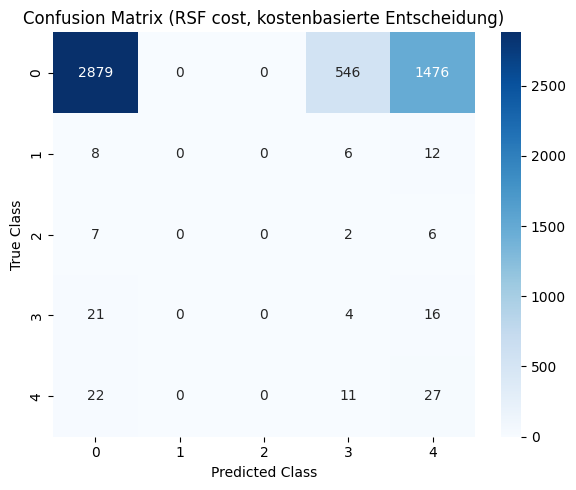

In [91]:
plot_confusion_matrix_from_csv(
    csv_path="../data/07_model_output/RSF/confusion_matrix_cost.csv",
    output_path="../data/07_model_output/RSF/confusion_matrix_cost.png",
    title_survix="RSF cost"
)

Confusion matrix heatmap saved to ../data/07_model_output/RSF_test/confusion_matrix_cost.png


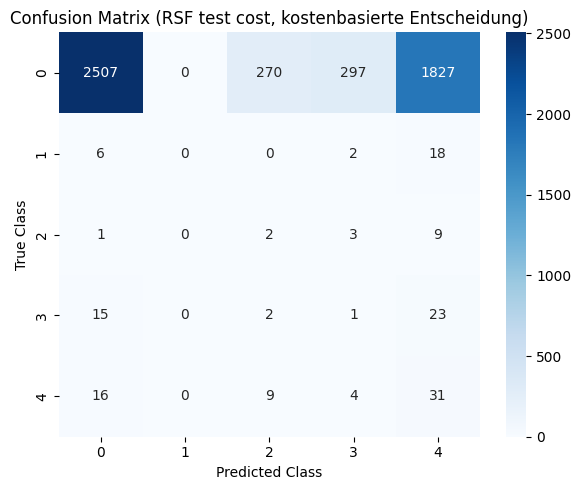

In [92]:
plot_confusion_matrix_from_csv(
    csv_path="../data/07_model_output/RSF_test/confusion_matrix_cost.csv",
    output_path="../data/07_model_output/RSF_test/confusion_matrix_cost.png",
    title_survix="RSF test cost"
)

Confusion matrix heatmap saved to ../data/07_model_output/RSF/confusion_matrix_argmax.png


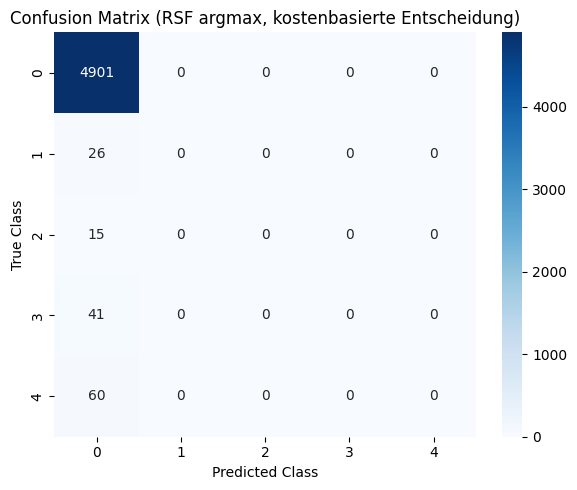

In [93]:
plot_confusion_matrix_from_csv(
    csv_path="../data/07_model_output/RSF/confusion_matrix_argmax.csv",
    output_path="../data/07_model_output/RSF/confusion_matrix_argmax.png",
    title_survix="RSF argmax"
)

Confusion matrix heatmap saved to ../data/07_model_output/RSF_test/confusion_matrix_argmax.png


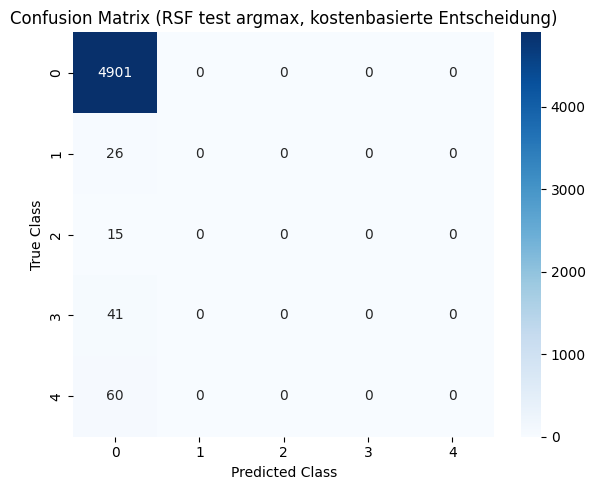

In [94]:
plot_confusion_matrix_from_csv(
    csv_path="../data/07_model_output/RSF_test/confusion_matrix_argmax.csv",
    output_path="../data/07_model_output/RSF_test/confusion_matrix_argmax.png",
    title_survix="RSF test argmax"
)

### 2. XGBoost

#### 2.1 Brier-Score

In [ ]:
def aft_brier_score_on_test(
    booster: xgb.Booster,
    dtest: xgb.DMatrix,
    y_train_surv: np.ndarray,
    y_test_surv: np.ndarray,
    sigma: float,
    output_base: str = "../data/07_model_output",
    model_subdir: str = "AFT",
    time_grid: np.ndarray | None = None,
    n_grid: int = 100
) -> dict:
    """
    Berechnet den integrierten Brier Score (IBS) für ein AFT-Modell.

    Args:
        booster: Trainiertes XGBoost AFT Modell.
        dtest: Testdaten als xgb.DMatrix.
        y_train_surv: Train-Survivaldaten (für Zensurgewichtung).
        y_test_surv: Test-Survivaldaten (für Evaluation, letzter Readout pro Fahrzeug).
        sigma: Skalenparameter des AFT-Modells.
        output_base: Basisordner für Outputs.
        model_subdir: Unterordner, z. B. "AFT".
        time_grid: Optional vordefinierte Zeitpunkte. Wenn None → gleichmäßig bis tau.
        n_grid: Anzahl der Punkte für das Zeitraster.

    Returns:
        dict mit IBS, tau, times, brier_scores, Pfad zur JSON-Datei.
    """
    out_dir = os.path.join(output_base, model_subdir)
    ensure_dir(out_dir)

    # Maximale Eventzeit im Test (nur Events!)
    tau = float(y_test_surv["time"][y_test_surv["event"]].max())

    # Zeitraster
    if time_grid is None:
        times = np.linspace(1.0, tau, n_grid)
    else:
        times = np.asarray(time_grid, dtype=float)

    # Survivalmatrix S(t) für alle Zeitpunkte berechnen
    mu = booster.predict(dtest)  # Erwartungswert (shape N,)
    sigma = float(sigma)
    sigma = max(sigma, 1e-3)

    S = np.stack([
        1.0 - scipy.stats.norm.cdf(t, loc=mu, scale=sigma)
        for t in times
    ], axis=1)  # (N, len(times))

    # Brier Score
    brier_scores, _ = brier_score(y_train_surv, y_test_surv, S, times)
    ibs = float(np.trapz(brier_scores, times) / (times[-1] - times[0]))

    results = {
        "ibs": ibs,
        "tau": tau,
        "times": times.tolist(),
        "brier_scores": brier_scores.tolist(),
    }

    out_path = os.path.join(out_dir, "brier_score.json")
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2)
    results["path"] = out_path

    return results

### Anwendung

In [215]:
dtest = prepare_aft_model_input(load_df(ordner="04_feature", name = "feature_test_corr_labels"), columns_to_drop=["duration", "event", "vehicle_id", "class_label", "upper_bound"])


In [216]:
x_test, y_test = prepare_rsf_model_input(load_df(ordner="04_feature", name = "feature_test_corr_labels").drop(columns=["upper_bound"]), columns_to_drop=["duration", "event", "vehicle_id", "class_label"], frag=1.0, class_column="class_label", sampling=False) 
x_train, y_train = prepare_rsf_model_input(load_df(ordner="04_feature", name = "feature_train_corr_labels").drop(columns=["upper_bound"]), columns_to_drop=["duration", "event", "vehicle_id", "class"], frag=1.0, class_column="class", sampling=False) 


In [217]:
best_params = load_df(ordner="05_model_input", name="atf_best_params_totalcost")

In [218]:
aft_model_final = load_model("AFT_final_model")

In [224]:
results_brier_aft = aft_brier_score_on_test(
    booster=aft_model_final,
    dtest=dtest,
    y_train_surv=y_train,   # alle Readouts
    y_test_surv=y_test,     # nur letzter Readout pro Fahrzeug
    sigma=float(best_params["aft_loss_distribution_scale"]),
    model_subdir="AFT"
)
print(results_brier_aft)

/tmp/ipykernel_2068/1047054151.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma=float(best_params["aft_loss_distribution_scale"]),


{'ibs': 24.0, 'tau': 47.0, 'times': [1.0, 1.9387755102040818, 2.8775510204081636, 3.816326530612245, 4.755102040816327, 5.6938775510204085, 6.63265306122449, 7.571428571428572, 8.510204081632654, 9.448979591836736, 10.387755102040817, 11.326530612244898, 12.26530612244898, 13.204081632653061, 14.142857142857144, 15.081632653061225, 16.02040816326531, 16.95918367346939, 17.89795918367347, 18.836734693877553, 19.775510204081634, 20.714285714285715, 21.653061224489797, 22.591836734693878, 23.53061224489796, 24.46938775510204, 25.408163265306122, 26.346938775510207, 27.28571428571429, 28.22448979591837, 29.16326530612245, 30.102040816326532, 31.040816326530614, 31.979591836734695, 32.91836734693878, 33.85714285714286, 34.79591836734694, 35.734693877551024, 36.673469387755105, 37.61224489795919, 38.55102040816327, 39.48979591836735, 40.42857142857143, 41.36734693877551, 42.30612244897959, 43.244897959183675, 44.183673469387756, 45.12244897959184, 46.06122448979592, 47.0], 'brier_scores': [1

#### 2.2 Kostenanalyse

#### Daten vorbereiten

In [139]:
dtest = prepare_rsf_model_input(load_df(ordner="04_feature", name = "feature_test_corr_labels"), columns_to_drop=["duration", "event", "vehicle_id", "class_label", "upper_bound"])
labels_test = load_df(ordner="04_feature", name = "feature_test_corr_labels")["class_label"]


In [111]:
best_params = load_df(ordner="05_model_input", name="atf_best_params_totalcost")

#### predict survival function

In [158]:
def predict_survival_prob(booster: xgb.Booster, d: xgb.DMatrix, sigma: float) -> np.ndarray:
    """
    Predict survival probabilities at specified time points using an XGBoost AFT model.

    Args:
        booster: Trained XGBoost Booster.
        dval: xgb.DMatrix with data.
        sigma: Scale parameter (float).

    Returns:
        np.ndarray: Survival probs at TAUS, shape (N, len(TAUS)).
    """
    mu = booster.predict(d)  # (n_samples,)
    sigma = float(sigma)
    sigma = max(sigma, 1e-3)

    S = np.stack([
        1.0 - scipy.stats.norm.cdf(tau, loc=mu, scale=sigma)
        for tau in TAUS
    ], axis=1)

    return S


#### decider function

In [159]:
def decide_with_cost_from_aft_at_taus(
    booster: xgb.Booster,
    dmatrix: xgb.DMatrix,
    taus: np.ndarray,
    cost: np.ndarray,
    sigma: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Entscheidet je Instanz nach minimaler erwarteter Kostenklasse auf Basis
    eines XGBoost AFT-Modells.

    Args:
        booster: Trainiertes XGBoost AFT Modell (xgb.Booster).
        dmatrix: Eingabedaten als xgb.DMatrix.
        taus: Klassengrenzen (4,).
        cost: Kostenmatrix (5,5).
        sigma: AFT-Scale-Parameter.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]:
            pred_class: Länge N, vorhergesagte Klasse {0..4}.
            exp_cost_min: Länge N, minimale erwartete Kosten.
            probs: Matrix (N,5) mit Wahrscheinlichkeiten p0..p4.
    """
    # Survivalwahrscheinlichkeiten an TAUS berechnen
    S_tau = predict_survival_prob(d=dmatrix, booster=booster, sigma=sigma)  # (N,4)

    N = S_tau.shape[0]
    pred_class = np.zeros(N, dtype=int)
    exp_cost_min = np.zeros(N, dtype=float)
    probs = np.zeros((N, 5), dtype=float)

    for i, s in enumerate(S_tau):
        p = class_probs_from_S_tau(s)
        exp_vec = cost.T @ p
        m_hat = int(np.argmin(exp_vec))
        pred_class[i] = m_hat
        exp_cost_min[i] = float(exp_vec[m_hat])
        probs[i, :] = p

    return pred_class, exp_cost_min, probs


In [153]:
def evaluate_and_save_cost_decision_aft(
    booster: xgb.Booster,
    dmatrix: xgb.DMatrix,
    true_class: np.ndarray,
    taus: np.ndarray,
    cost: np.ndarray,
    sigma: float,
    output_dir: str = "../data/07_model_output/AFT",
    save_probs: bool = False,
    survix: str = "cost"
) -> dict:
    """
    Führt die kostenbasierte Entscheidung mit einem XGBoost AFT Modell durch,
    berechnet realisierte Kosten & Genauigkeit und speichert Artefakte.

    Args:
        booster: Trainiertes AFT-Booster-Modell.
        dmatrix: Daten als xgb.DMatrix.
        true_class: Wahre Klassenlabels {0..4}.
        taus: Klassengrenzen [tau1..tau4].
        cost: Kostenmatrix (5x5).
        sigma: Scale-Parameter des AFT-Modells.
        output_dir: Zielverzeichnis.
        save_probs: Ob p0..p4 gespeichert werden sollen.
        survix: Suffix für Dateinamen.

    Returns:
        dict mit Pfaden & Kennzahlen.
    """
    ensure_dir(output_dir)

    pred_class, exp_cost_min, probs = decide_with_cost_from_aft_at_taus(
        booster, dmatrix, taus, cost, sigma
    )
    avg_cost, total_cost, cm, accuracy = evaluate_decision_costs_from_true(
        true_class, pred_class, cost
    )

    metrics = {
        "avg_realised_cost": float(avg_cost),
        "total_realised_cost": float(total_cost),
        "accuracy": float(accuracy),
        "n_instances": int(len(pred_class)),
        "taus": list(map(float, taus)),
    }

    metrics_path = os.path.join(output_dir, f"metrics_{survix}.json")
    cm_path = os.path.join(output_dir, f"confusion_matrix_{survix}.csv")
    probs_path = os.path.join(output_dir, f"class_probs_{survix}.csv")

    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)

    pd.DataFrame(cm, index=[0, 1, 2, 3, 4], columns=[0, 1, 2, 3, 4]).to_csv(cm_path, index=True)

    if save_probs:
        pd.DataFrame(probs, columns=[f"p{c}" for c in range(5)]).to_csv(probs_path, index=False)

    return {
        "metrics_path": metrics_path,
        "confusion_matrix_path": cm_path,
        "class_probs_path": probs_path if save_probs else None,
        "avg_realised_cost": float(avg_cost),
        "total_realised_cost": float(total_cost),
        "accuracy": float(accuracy),
    }


#### Evaulation function

In [124]:
def run_aft_cost_evaluation(
    booster: xgb.Booster,
    dmatrix: xgb.DMatrix,
    true_classes: np.ndarray,
    taus: np.ndarray,
    cost: np.ndarray,
    sigma: float,
    output_dir: str = "../data/07_model_output/AFT",
    save_probs: bool = True,
    survix: str = "cost"
) -> dict:
    """
    Führt eine vollständige Kosten-Evaluation für ein trainiertes XGBoost-AFT Modell durch.

    Args:
        booster: Trainiertes XGBoost Booster Modell (AFT).
        dmatrix: Eingabedaten (Validation oder Test) als xgb.DMatrix.
        true_classes: Wahre Klassenlabels {0..4}.
        taus: Klassengrenzen [tau1..tau4].
        cost: Kostenmatrix (5x5).
        sigma: Scale-Parameter des AFT-Modells.
        output_dir: Zielverzeichnis für Artefakte.
        save_probs: Ob Klassenwahrscheinlichkeiten gespeichert werden sollen.
        survix: Suffix für Dateinamen ("cost", "argmax" usw.).

    Returns:
        dict: Enthält Pfade zu gespeicherten Artefakten und Kennzahlen.
    """
    results = evaluate_and_save_cost_decision_aft(
        booster=booster,
        dmatrix=dmatrix,
        true_class=true_classes,
        taus=taus,
        cost=cost,
        sigma=sigma,
        output_dir=output_dir,
        save_probs=save_probs,
        survix=survix,
    )

    print("AFT Evaluation Results:")
    for k, v in results.items():
        print(f"  {k}: {v}")

    return results


#### Anwendung

In [120]:
aft_model_final = load_model("AFT_final_model")

In [ ]:
dvalidation = prepare_rsf_model_input(load_df(ordner="04_feature", name = "feature_validation_corr_labels"), columns_to_drop=["duration", "event", "vehicle_id", "class_label", "upper_bound"])
labels_vali = load_df(ordner="04_feature", name = "feature_validation_corr_labels")["class_label"]

In [177]:
results_aft_cost = run_aft_cost_evaluation(
    booster=aft_model_final,
    dmatrix=dtest,
    true_classes=labels_test.to_numpy(),
    taus=TAUS,
    cost=COST,
    sigma=float(best_params["aft_loss_distribution_scale"]),
    output_dir="../data/07_model_output/AFT",
    save_probs=True,
    survix="cost"
)


AFT Evaluation Results:
  metrics_path: ../data/07_model_output/AFT/metrics_cost.json
  confusion_matrix_path: ../data/07_model_output/AFT/confusion_matrix_cost.csv
  class_probs_path: ../data/07_model_output/AFT/class_probs_cost.csv
  avg_realised_cost: 9.295855641483245
  total_realised_cost: 46879.0
  accuracy: 0.42752329962324015


/tmp/ipykernel_2068/4075226449.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma=float(best_params["aft_loss_distribution_scale"]),


#### Entscheidung nach Argmax

#### decider function

In [161]:
def decide_with_argmax_from_aft_at_taus(
    booster: xgb.Booster,
    dmatrix: xgb.DMatrix,
    taus: np.ndarray,
    sigma: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Entscheidet je Instanz nach der Klasse mit maximaler Wahrscheinlichkeit (argmax).

    Args:
        booster: Trainiertes XGBoost AFT Modell.
        dmatrix: Eingabedaten als xgb.DMatrix.
        taus: Klassengrenzen [tau1..tau4].
        sigma: AFT Scale-Parameter.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]:
            pred_class: Länge N, vorhergesagte Klasse {0..4}.
            max_probs: Länge N, zugehörige max. Wahrscheinlichkeit.
            probs: Matrix (N,5) mit Wahrscheinlichkeiten p0..p4.
    """
    # Survivalwahrscheinlichkeiten S(tau) berechnen
    S_tau = predict_survival_prob(booster, dmatrix, sigma=sigma)  # (N,4)

    N = S_tau.shape[0]
    probs = np.vstack([class_probs_from_S_tau(S_tau[i, :]) for i in range(N)])  # (N,5)

    pred_class = probs.argmax(axis=1).astype(int)
    max_probs = probs[np.arange(N), pred_class]
    return pred_class, max_probs, probs


In [162]:
def evaluate_and_save_argmax_decision_aft(
    booster: xgb.Booster,
    dmatrix: xgb.DMatrix,
    true_class: np.ndarray,
    taus: np.ndarray,
    cost: np.ndarray,
    sigma: float,
    output_dir: str = "../data/07_model_output/AFT",
    save_probs: bool = False,
    survix: str = "argmax"
) -> dict:
    """
    Führt die argmax-Entscheidung mit einem XGBoost AFT Modell durch,
    berechnet realisierte Kosten & Genauigkeit und speichert Artefakte.

    Args:
        booster: Trainiertes AFT-Booster-Modell.
        dmatrix: Daten als xgb.DMatrix.
        true_class: Wahre Klassen {0..4}.
        taus: Klassengrenzen [tau1..tau4].
        cost: Kostenmatrix (5x5).
        sigma: Scale-Parameter des AFT-Modells.
        output_dir: Zielverzeichnis.
        save_probs: Ob Wahrscheinlichkeiten gespeichert werden sollen.
        survix: Suffix für Dateinamen.

    Returns:
        dict: Pfade zu gespeicherten Artefakten und Kennzahlen.
    """
    ensure_dir(output_dir)

    pred_class, max_probs, probs = decide_with_argmax_from_aft_at_taus(
        booster, dmatrix, taus, sigma
    )
    avg_cost, total_cost, cm, accuracy = evaluate_decision_costs_from_true(
        true_class, pred_class, cost
    )

    metrics = {
        "avg_realised_cost": float(avg_cost),
        "total_realised_cost": float(total_cost),
        "accuracy": float(accuracy),
        "n_instances": int(len(pred_class)),
        "taus": list(map(float, taus)),
    }

    metrics_path = os.path.join(output_dir, f"metrics_{survix}.json")
    cm_path = os.path.join(output_dir, f"confusion_matrix_{survix}.csv")
    probs_path = os.path.join(output_dir, f"class_probs_{survix}.csv")

    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)

    pd.DataFrame(cm, index=[0, 1, 2, 3, 4], columns=[0, 1, 2, 3, 4]).to_csv(cm_path, index=True)

    if save_probs:
        pd.DataFrame(probs, columns=[f"p{c}" for c in range(5)]).to_csv(probs_path, index=False)

    return {
        "metrics_path": metrics_path,
        "confusion_matrix_path": cm_path,
        "class_probs_path": probs_path if save_probs else None,
        "avg_realised_cost": float(avg_cost),
        "total_realised_cost": float(total_cost),
        "accuracy": float(accuracy),
    }


In [163]:
def run_aft_argmax_evaluation(
    booster: xgb.Booster,
    dmatrix: xgb.DMatrix,
    true_classes: np.ndarray,
    taus: np.ndarray,
    cost: np.ndarray,
    sigma: float,
    output_dir: str = "../data/07_model_output/AFT",
    save_probs: bool = True,
    survix: str = "argmax"
) -> dict:
    """
    Wrapper für die Argmax-Evaluation mit XGBoost AFT.
    """
    results = evaluate_and_save_argmax_decision_aft(
        booster=booster,
        dmatrix=dmatrix,
        true_class=true_classes,
        taus=taus,
        cost=cost,
        sigma=sigma,
        output_dir=output_dir,
        save_probs=save_probs,
        survix=survix,
    )

    print("AFT Argmax Evaluation Results:")
    for k, v in results.items():
        print(f"  {k}: {v}")

    return results


#### Anwendung

In [178]:
results_aft_argmax = run_aft_argmax_evaluation(
    booster=aft_model_final,
    dmatrix=dtest,
    true_classes=labels_test.to_numpy(),
    taus=TAUS,
    cost=COST,
    sigma=float(best_params["aft_loss_distribution_scale"]),
    output_dir="../data/07_model_output/AFT",
    save_probs=True,
    survix="argmax"
)
print(results_aft_argmax)

AFT Argmax Evaluation Results:
  metrics_path: ../data/07_model_output/AFT/metrics_argmax.json
  confusion_matrix_path: ../data/07_model_output/AFT/confusion_matrix_argmax.csv
  class_probs_path: ../data/07_model_output/AFT/class_probs_argmax.csv
  avg_realised_cost: 9.295855641483245
  total_realised_cost: 46879.0
  accuracy: 0.42752329962324015
{'metrics_path': '../data/07_model_output/AFT/metrics_argmax.json', 'confusion_matrix_path': '../data/07_model_output/AFT/confusion_matrix_argmax.csv', 'class_probs_path': '../data/07_model_output/AFT/class_probs_argmax.csv', 'avg_realised_cost': 9.295855641483245, 'total_realised_cost': 46879.0, 'accuracy': 0.42752329962324015}


/tmp/ipykernel_2068/3022092098.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma=float(best_params["aft_loss_distribution_scale"]),


In [166]:
pred_class_cost, _, _ = decide_with_cost_from_aft_at_taus(aft_model_final, dtest, TAUS, COST, sigma=float(best_params["aft_loss_distribution_scale"]))
pred_class_argmax, _, _ = decide_with_argmax_from_aft_at_taus(aft_model_final, dtest, TAUS, sigma=float(best_params["aft_loss_distribution_scale"]))

print("Klassen-Unterschiede:", (pred_class_cost != pred_class_argmax).sum())


Klassen-Unterschiede: 0


/tmp/ipykernel_2068/199249728.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pred_class_cost, _, _ = decide_with_cost_from_aft_at_taus(aft_model_final, dtest, TAUS, COST, sigma=float(best_params["aft_loss_distribution_scale"]))
/tmp/ipykernel_2068/199249728.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pred_class_argmax, _, _ = decide_with_argmax_from_aft_at_taus(aft_model_final, dtest, TAUS, sigma=float(best_params["aft_loss_distribution_scale"]))


#### Confusion-Matrix

Confusion matrix heatmap saved to ../data/07_model_output/AFT/confusion_matrix_cost.png


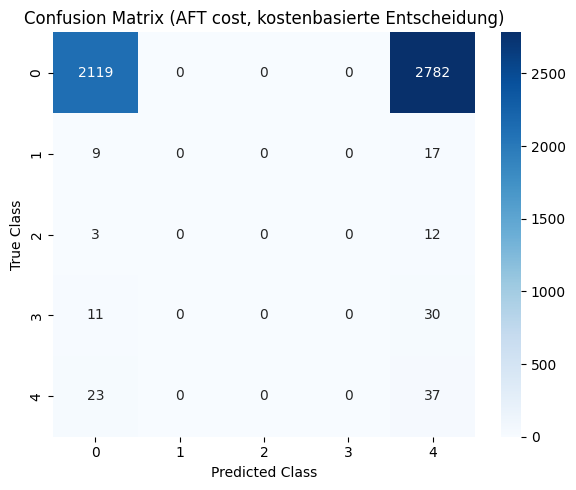

In [179]:
plot_confusion_matrix_from_csv(
    csv_path="../data/07_model_output/AFT/confusion_matrix_cost.csv",
    output_path="../data/07_model_output/AFT/confusion_matrix_cost.png",
    title_survix="AFT cost"
)

Confusion matrix heatmap saved to ../data/07_model_output/AFT/confusion_matrix_argmax.png


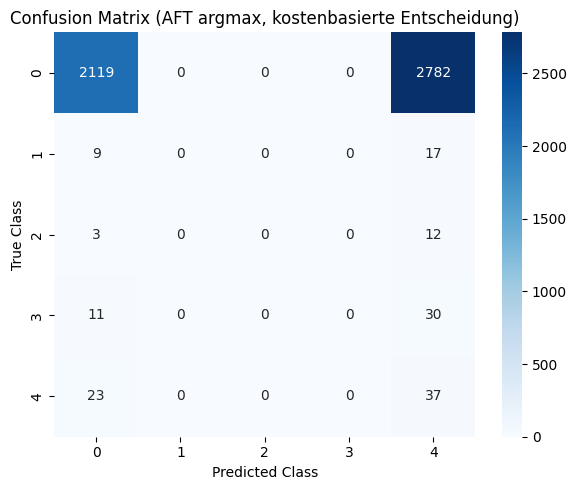

In [180]:
plot_confusion_matrix_from_csv(
    csv_path="../data/07_model_output/AFT/confusion_matrix_argmax.csv",
    output_path="../data/07_model_output/AFT/confusion_matrix_argmax.png",
    title_survix="AFT argmax"
)